# Ant Colony System for the TSP

In [1]:
!rm -r AI2021MA/
!git clone https://github.com/UmbertoJr/AI2021MA.git &> /dev/null

rm: cannot remove 'AI2021MA/': No such file or directory


name: eil76
nPoints: 76
best_sol: 538.0


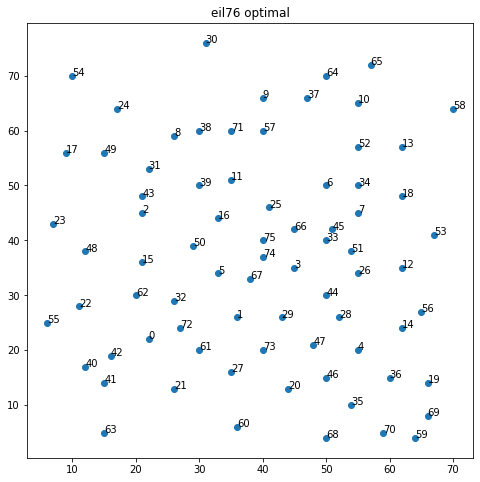


--------------------------------------------------------------

name: ch130
nPoints: 130
best_sol: 6110.0


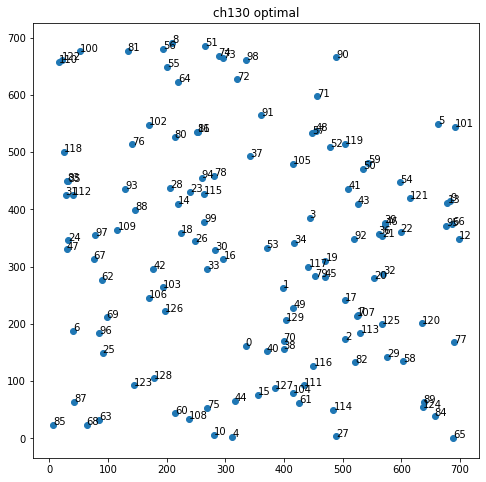


--------------------------------------------------------------

name: d198
nPoints: 198
best_sol: 15780.0


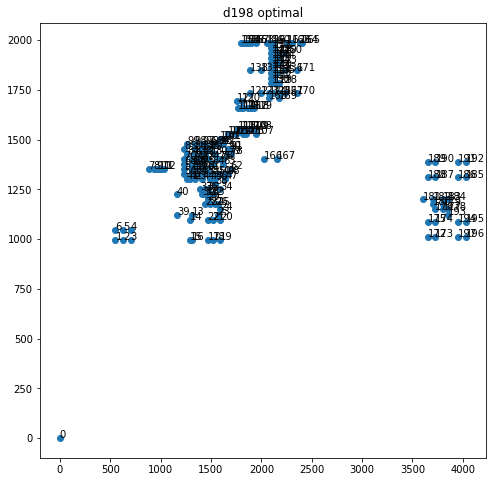

In [2]:
from AI2021MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
# from IO_manager.io_tsp import TSP_Instance_Creator

ic1 = TSP_Instance_Creator("standard", 'eil76.tsp')
ic1.print_info()
ic1.plot_data()
print('\n--------------------------------------------------------------\n')
ic2 = TSP_Instance_Creator("standard", 'ch130.tsp')
ic2.print_info()
ic2.plot_data()
print('\n--------------------------------------------------------------\n')
ic3 = TSP_Instance_Creator("standard", 'd198.tsp')
ic3.print_info()
ic3.plot_data()

In [3]:
import numpy as np
from AI2021MA.solvers.local_search import twoOpt
from AI2021MA.solvers.two_opt_with_candidate import twoOpt_with_cl
from AI2021MA.solvers.constructive_algorithms import nn, compute_lenght
import time

# nn takes as input the distance matrix and returns 
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix 
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  m = 10              # number of ants 
  beta = 2            # fixed parameter for use in sampling exploration vs. exploitation
  alpha = rho = 0.1   # global/local evaporistation factors
  cl = 15             # candidate list length

  @staticmethod
  def take_candidates(j, dist_mat):  # looks at city j and returns candidate list of cl closest cities to j
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])

  def take_remaining(self, j, dist_mat): # looks at city j and returns indices of closest cities beyond candidate list
    return list(np.argsort(dist_mat[j])[ACS.cl:])

  def __init__(self, instance, q_0, seed):
    self.ic = instance
    self.seed = seed
    np.random.seed(seed)
    self.n = instance.nPoints                  # number of points/cities in the instance
    self.dist_mat = instance.dist_matrix       # distance matrix of the instance
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n)) # returns nearest neighbour solution of the instance and length thereof
    self.tau0 = 1./(float(self.n) * self.L_nn)        
    self.tour = {i: [] for i in range(ACS.m)}  # tour collector for the ants
    '''
    INITIALISATION PHASE
    '''
    self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)} # initialises the pheromone to tau 0 at the beginning, each key is a city
    self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(self.n)} #dict of candidate lists for each city
    self.position = {i: None for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps, initialised randomly

    self.eta = {r: [1/self.dist_mat[r][s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)} # want to maximise eta, therefore take the smallest (r,s) path when exploiting
    self.q_0 = q_0    # factor that decides how much exploration will be done vs. exploitation - 3 variants: 0.5, 0.98, (1-13/n) where n is number of cities
    
  def run(self):
    within_time_limit = True
    timeout = time.time() + 3*60
    tour_no = 0
    self.best_distance_list = [] # best tour distances for each round
    self.overall_best = 10000000 # checker for lower valued best tour
    self.len_to_plot = []
    while within_time_limit:
      
      if time.time() > timeout: 
        break
      tour_no += 1
      self.available_positions = {i: [j for j in range(self.n)] for i in range(ACS.m)} # list of available cities left to traverse for each ant ({all cities}-tour_k)
      #initialising positions of the ants randomly at the start of the tour
      self.position = {i: np.random.randint(0, high=self.n) for i in range(ACS.m)} 
      self.tour_distance = {i: 0.0 for i in range(ACS.m)} 
      #reset tour
      self.tour = {i: [] for i in range(ACS.m)}

        
      for ant in range(len(self.available_positions)): # removing starting city of each ant from their list of available cities 
        del(self.available_positions[ant][self.position[ant]])
      
      r_k = self.position.copy() # starting positions
      return_home = self.position.copy()
      
      for step in range(self.n): 
        if step < self.n-1:
          # check for intersection between each ant's not-yet visited cities and the candidate list of current position
          overlap = {x: list(set(self.available_positions[x]) & set(self.candidate_list[self.position[x]])) for x in range(len(self.position))}
          # print(self.available_positions)
          # print(self.candidate_list)
          # print(overlap)
          # print('---------------')
          for ant in range(len(self.position)):
            # check there's 1 or more available cities which to exploit/explore for every ant 
            if len(overlap[ant]) > 0:
              overlap_pheromone = []
              overlap_eta = []
              for overlap_city in overlap[ant]:
                candidate_idx = self.candidate_list[r_k[ant]].index(overlap_city)
                overlap_pheromone.append(self.pheromone[r_k[ant]][candidate_idx])
                overlap_eta.append(self.eta[r_k[ant]][candidate_idx])

              poss_transitions = overlap_pheromone*np.power(overlap_eta, ACS.beta) 
              q = np.random.rand()
              
              # exploitation case
              if q <= self.q_0:
                s = max(poss_transitions)
                self.position[ant] = overlap[ant][np.where(poss_transitions == s)[0][0]]
              
              # exploration case
              else: 
                summed_trans = sum(poss_transitions)
                # generates list of probabilities that sum to 1 be pseudo-randomly picked
                prob_array = [i / summed_trans for i in poss_transitions]
                n = len(poss_transitions)
                idx = np.random.choice(list(range(n)), p=prob_array)
                self.position[ant] = overlap[ant][idx]

              trans_idx = self.candidate_list[r_k[ant]].index(self.position[ant])
              #LOCAL transition rule
              self.pheromone[r_k[ant]][trans_idx] = (1 - ACS.rho) * self.pheromone[r_k[ant]][trans_idx] + ACS.rho * self.tau0

            else: # case of no overlap - find nearest unvisited city within available_positions
              next_best = self.take_remaining(r_k[ant], self.dist_mat)
              remaining_overlap = list(set(self.available_positions[ant]) & set(next_best))
              self.position[ant] = remaining_overlap[0]

            # updating s_k into each tour, creating tuple of (r_k,s_k)
            self.tour[ant].append((r_k[ant], self.position[ant]))

            # incrementing tour distance of each ant by distance traversed in transition
            self.tour_distance[ant] += self.dist_mat[r_k[ant], self.position[ant]]
            r_k[ant] = self.position[ant] # make s_k -> next r_k for following iter
            del_idx = self.available_positions[ant].index(self.position[ant])
            del(self.available_positions[ant][del_idx]) #remove visited city from available positions
      
        else: # ants travel back to first city
          for ant in range(ACS.m):
            self.tour[ant].append((r_k[ant], return_home[ant])) # final step of tour
            # incrementing tour distance of each ant by distance traversed in transition
            self.tour_distance[ant] += self.dist_mat[r_k[ant], return_home[ant]]

      # global best here, do for just best ant in the iteration
      best_tour_distance = min([self.tour_distance[i] for i in self.tour_distance])
      best_tour_idx = list(self.tour_distance.values()).index(best_tour_distance)
     
      # statistics
      self.best_tour_listed = [self.tour[best_tour_idx][i][0] for i in range(self.n)]
      self.best_tour_listed.append(self.tour[best_tour_idx][0][0]) #add the first city to the end of the list
      
      '''
      # 2-opt no CL - Uncomment to run without candidate lists
      self.tour, len_new = twoOpt(self.best_tour_listed, best_tour_distance, self.dist_mat)
      '''
       
      
      # uncomment the above '''''' and comment out the line below to run without candidate lists
      # 2-opt with CL modification
      self.tour, len_new = twoOpt_with_cl(self.best_tour_listed, best_tour_distance, self.dist_mat, self.candidate_list) 
      
      if len_new < self.overall_best:
        self.tour_num_of_best = tour_no # to keep track of which tour number the new best is found at
        self.best_distance_list.append(len_new)
      else:
        self.best_distance_list.append(self.best_distance_list[-1]) # if no new best found this tour, best distance is same as last time
      self.len_to_plot.append(len_new)
      self.overall_best = min(self.best_distance_list)
      self.best_tour_listed.append(self.tour)
      print('___________________________________________________________________')
      print('Tour no: ', tour_no, ' length: ', len_new, ' with overall best: ', self.overall_best, ' achieved at iteration: ', self.tour_num_of_best)  
      
      # global update
      for city in range(len(self.pheromone)):
        for connection in range(len(self.pheromone[city])):
          self.pheromone[city][connection] = (1 - ACS.alpha) * self.pheromone[city][connection]
          if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour
            self.pheromone[city][connection] += ACS.alpha * 1/best_tour_distance
      

In [14]:

'''
Naming convention of objects: acs_[map]_[exploration threshold]_[seed]

2opt WITH Candidate Lists
'''

#2opt with CL
acs_eil76_05_0 = ACS(ic1, q_0=0.5, seed=0)
acs_eil76_05_1 = ACS(ic1, q_0=0.5, seed=1)
acs_eil76_05_2 = ACS(ic1, q_0=0.5, seed=2)

acs_eil76_098_0 = ACS(ic1, q_0=0.98, seed=0)
acs_eil76_098_1 = ACS(ic1, q_0=0.98, seed=1)
acs_eil76_098_2 = ACS(ic1, q_0=0.98, seed=2)

acs_eil76_13n_0 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=0)
acs_eil76_13n_1 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=1)
acs_eil76_13n_2 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=2)

acs_ch130_05_0 = ACS(ic2, q_0=0.5, seed=0)
acs_ch130_05_1 = ACS(ic2, q_0=0.5, seed=1)
acs_ch130_05_2 = ACS(ic2, q_0=0.5, seed=2)

acs_ch130_098_0 = ACS(ic2, q_0=0.98, seed=0)
acs_ch130_098_1 = ACS(ic2, q_0=0.98, seed=1)
acs_ch130_098_2 = ACS(ic2, q_0=0.98, seed=2)

acs_ch130_13n_0 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=0)
acs_ch130_13n_1 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=1)
acs_ch130_13n_2 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=2)

acs_d198_05_0 = ACS(ic3, q_0=0.5, seed=0)
acs_d198_05_1 = ACS(ic3, q_0=0.5, seed=1)
acs_d198_05_2 = ACS(ic3, q_0=0.5, seed=2)

acs_d198_098_0 = ACS(ic3, q_0=0.98, seed=0)
acs_d198_098_1 = ACS(ic3, q_0=0.98, seed=1)
acs_d198_098_2 = ACS(ic3, q_0=0.98, seed=2)

acs_d198_13n_0 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=0)
acs_d198_13n_1 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=1)
acs_d198_13n_2 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=2)


In [ ]:
acs_eil76_05_0.run()
acs_eil76_05_1.run()
acs_eil76_05_2.run()

acs_eil76_098_0.run()
acs_eil76_098_1.run()
acs_eil76_098_2.run()

acs_eil76_13n_0.run()
acs_eil76_13n_1.run()
acs_eil76_13n_2.run()


In [ ]:
acs_ch130_05_0.run() 
acs_ch130_05_1.run() 
acs_ch130_05_2.run() 
 
acs_ch130_098_0.run()
acs_ch130_098_1.run()
acs_ch130_098_2.run()
 
acs_ch130_13n_0.run()
acs_ch130_13n_1.run()
acs_ch130_13n_2.run()

In [ ]:
 acs_d198_05_0.run() 
 acs_d198_05_1.run()
 acs_d198_05_2.run() 
  
 acs_d198_098_0.run()
 acs_d198_098_1.run()
 acs_d198_098_2.run()
  
 acs_d198_13n_0.run()
 acs_d198_13n_1.run()
 acs_d198_13n_2.run()

In [4]:
'''
Naming convention of objects: acs_[map]_[exploration threshold]_[seed]

#2opt WITHOUT Candidate Lists
'''


acs_eil76_05_cl_0 = ACS(ic1, q_0=0.5, seed=0) 
acs_eil76_05_cl_1 = ACS(ic1, q_0=0.5, seed=1)
acs_eil76_05_cl_2 = ACS(ic1, q_0=0.5, seed=2)

acs_eil76_098_cl_0 = ACS(ic1, q_0=0.98, seed=0)
acs_eil76_098_cl_1 = ACS(ic1, q_0=0.98, seed=1)
acs_eil76_098_cl_2 = ACS(ic1, q_0=0.98, seed=2)

acs_eil76_13n_cl_0 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=0)
acs_eil76_13n_cl_1 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=1)
acs_eil76_13n_cl_2 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=2)

acs_ch130_05_cl_0 = ACS(ic2, q_0=0.5, seed=0)
acs_ch130_05_cl_1 = ACS(ic2, q_0=0.5, seed=1)
acs_ch130_05_cl_2 = ACS(ic2, q_0=0.5, seed=2)

acs_ch130_098_cl_0 = ACS(ic2, q_0=0.98, seed=0)
acs_ch130_098_cl_1 = ACS(ic2, q_0=0.98, seed=1)
acs_ch130_098_cl_2 = ACS(ic2, q_0=0.98, seed=2)

acs_ch130_13n_cl_0 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=0)
acs_ch130_13n_cl_1 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=1)
acs_ch130_13n_cl_2 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=2)

acs_d198_05_cl_0 = ACS(ic3, q_0=0.5, seed=0)
acs_d198_05_cl_1 = ACS(ic3, q_0=0.5, seed=1)
acs_d198_05_cl_2 = ACS(ic3, q_0=0.5, seed=2)

acs_d198_098_cl_0 = ACS(ic3, q_0=0.98, seed=0)
acs_d198_098_cl_1 = ACS(ic3, q_0=0.98, seed=1)
acs_d198_098_cl_2 = ACS(ic3, q_0=0.98, seed=2)

acs_d198_13n_cl_0 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=0)
acs_d198_13n_cl_1 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=1)
acs_d198_13n_cl_2 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=2)

In [ ]:
acs_eil76_05_cl_0.run() 
acs_eil76_05_cl_1.run() 
acs_eil76_05_cl_2.run() 

acs_eil76_098_cl_0.run()
acs_eil76_098_cl_1.run()
acs_eil76_098_cl_2.run()

acs_eil76_13n_cl_0.run()
acs_eil76_13n_cl_1.run()
acs_eil76_13n_cl_2.run()

In [ ]:
 acs_ch130_05_cl_0.run() 
 acs_ch130_05_cl_1.run() 
 acs_ch130_05_cl_2.run() 
  
 acs_ch130_098_cl_0.run()
 acs_ch130_098_cl_1.run()
 acs_ch130_098_cl_2.run()
  
 acs_ch130_13n_cl_0.run()
 acs_ch130_13n_cl_1.run()
 acs_ch130_13n_cl_2.run()

In [ ]:
 acs_d198_05_cl_0.run() 
 acs_d198_05_cl_1.run() 
 acs_d198_05_cl_2.run() 
  
 acs_d198_098_cl_0.run()
 acs_d198_098_cl_1.run()
 acs_d198_098_cl_2.run()
  
 acs_d198_13n_cl_0.run()
 acs_d198_13n_cl_1.run()
 acs_d198_13n_cl_2.run()

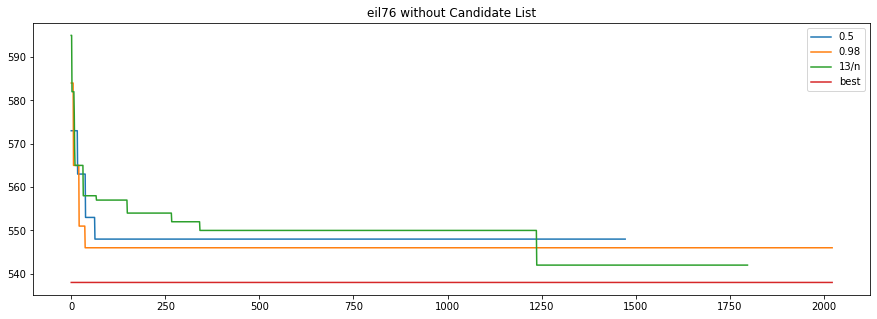

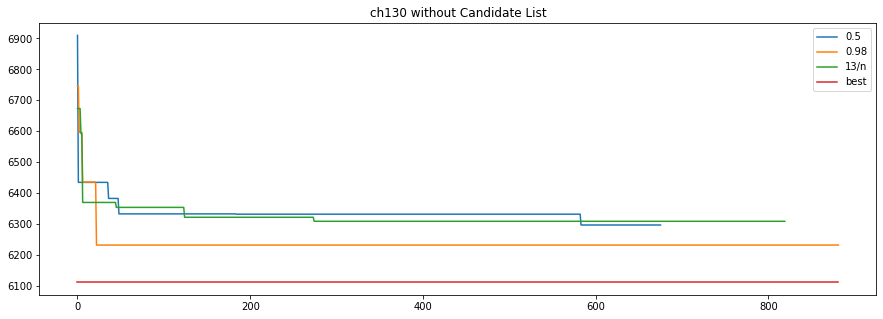

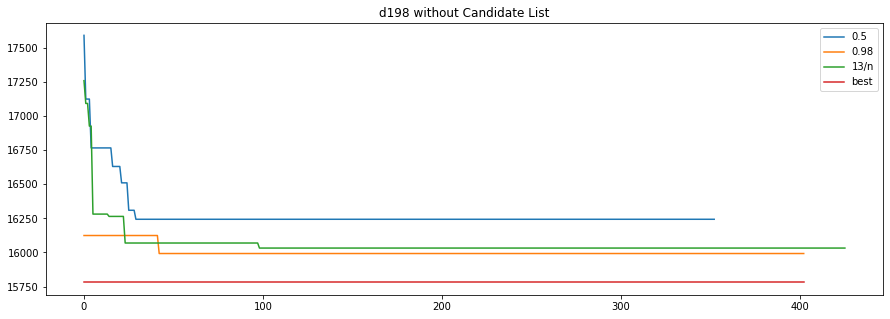

In [75]:
import matplotlib.pyplot as plt

'''
Cumulative best tour WITHOUT CL compared to optimal solution
'''

plt.figure(figsize=(15, 5))
plt.subplot(111)
plt.plot(range(len(acs_eil76_05_0.best_distance_list)), acs_eil76_05_0.best_distance_list, label='0.5')
plt.plot(range(len(acs_eil76_098_0.best_distance_list)), acs_eil76_098_0.best_distance_list, label='0.98')
plt.plot(range(len(acs_eil76_13n_0.best_distance_list)), acs_eil76_13n_0.best_distance_list, label='13/n')
plt.plot(range(len(acs_eil76_098_0.best_distance_list)), [ic1.best_sol for i in range(len(acs_eil76_098_0.best_distance_list))], label='best') #best sol
plt.title('eil76 without Candidate List')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(111)
plt.plot(range(len(acs_ch130_05_0.best_distance_list)), acs_ch130_05_0.best_distance_list, label='0.5')
plt.plot(range(len(acs_ch130_098_0.best_distance_list)), acs_ch130_098_0.best_distance_list, label='0.98')
plt.plot(range(len(acs_ch130_13n_0.best_distance_list)), acs_ch130_13n_0.best_distance_list, label='13/n')
plt.plot(range(len(acs_ch130_098_0.best_distance_list)), [ic2.best_sol for i in range(len(acs_ch130_098_0.best_distance_list))], label='best') #best sol
plt.title('ch130 without Candidate List')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(111)
plt.plot(range(len(acs_d198_05_0.best_distance_list)), acs_d198_05_0.best_distance_list, label='0.5')
plt.plot(range(len(acs_d198_098_0.best_distance_list)), acs_d198_098_0.best_distance_list, label='0.98')
plt.plot(range(len(acs_d198_13n_0.best_distance_list)), acs_d198_13n_0.best_distance_list, label='13/n')
plt.plot(range(len(acs_d198_098_0.best_distance_list)), [ic3.best_sol for i in range(len(acs_d198_098_0.best_distance_list))], label='best') #best sol
plt.title('d198 without Candidate List')
plt.legend()
plt.show()

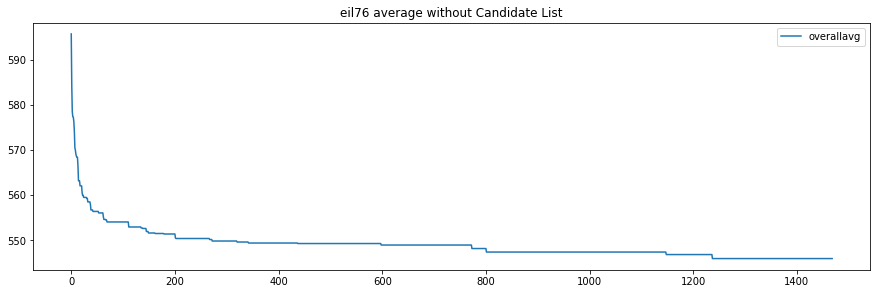

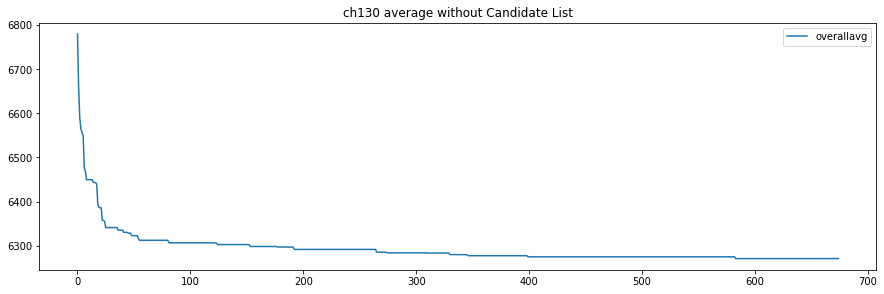

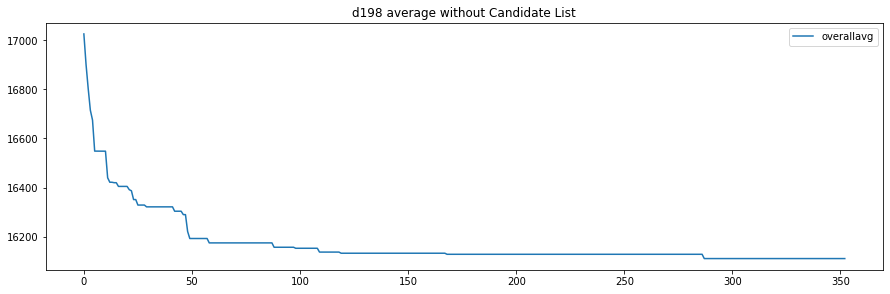

In [72]:
#mean values across iterations WITHOUT CL
 
avg05 = []
avg098 = []
avg13n = []
overall_avg = []
# eil76 stats
for i in range(len(acs_eil76_05_2.best_distance_list)): 
  avg05.append(acs_eil76_05_0.best_distance_list[i]/3 + acs_eil76_05_1.best_distance_list[i]/3 + acs_eil76_05_2.best_distance_list[i]/3) 
  avg098.append(acs_eil76_098_0.best_distance_list[i]/3 + acs_eil76_098_1.best_distance_list[i]/3 + acs_eil76_098_2.best_distance_list[i]/3)
  avg13n.append(acs_eil76_13n_0.best_distance_list[i]/3 + acs_eil76_13n_1.best_distance_list[i]/3 + acs_eil76_13n_2.best_distance_list[i]/3)
for i in range(len(acs_eil76_05_2.best_distance_list)) :
  overall_avg.append(avg05[i]/3 + avg098[i]/3 + avg13n[i]/3)
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('eil76 average without Candidate List')
plt.legend()
plt.show()

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# ch130 stats
for i in range(len(acs_ch130_05_2.best_distance_list)): 
  avg05.append(acs_ch130_05_0.best_distance_list[i]/3 + acs_ch130_05_1.best_distance_list[i]/3 + acs_ch130_05_2.best_distance_list[i]/3) 
  avg098.append(acs_ch130_098_0.best_distance_list[i]/3 + acs_ch130_098_1.best_distance_list[i]/3 + acs_ch130_098_2.best_distance_list[i]/3)
  avg13n.append(acs_ch130_13n_0.best_distance_list[i]/3 + acs_ch130_13n_1.best_distance_list[i]/3 + acs_ch130_13n_2.best_distance_list[i]/3)

for i in range(len(acs_ch130_05_2.best_distance_list)) :
  overall_avg.append(avg05[i]/3 + avg098[i]/3 + avg13n[i]/3)
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('ch130 average without Candidate List')
plt.legend()
plt.show()

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# d198 stats
for i in range(len(acs_d198_05_0.best_distance_list)): 
  avg05.append(acs_d198_05_0.best_distance_list[i]/3 + acs_d198_05_1.best_distance_list[i]/3 + acs_d198_05_2.best_distance_list[i]/3) 
  avg098.append(acs_d198_098_0.best_distance_list[i]/3 + acs_d198_098_1.best_distance_list[i]/3 + acs_d198_098_2.best_distance_list[i]/3)
  avg13n.append(acs_d198_13n_0.best_distance_list[i]/3 + acs_d198_13n_1.best_distance_list[i]/3 + acs_d198_13n_2.best_distance_list[i]/3)

for i in range(len(acs_d198_05_0.best_distance_list)) :
  overall_avg.append(avg05[i]/3 + avg098[i]/3 + avg13n[i]/3)
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('d198 average without Candidate List')
plt.legend()
plt.show()

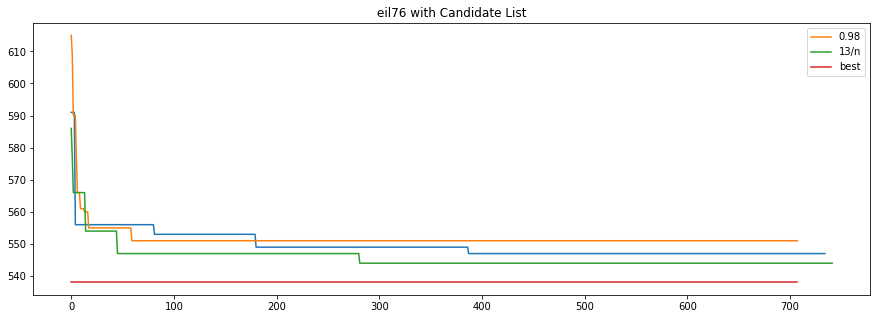

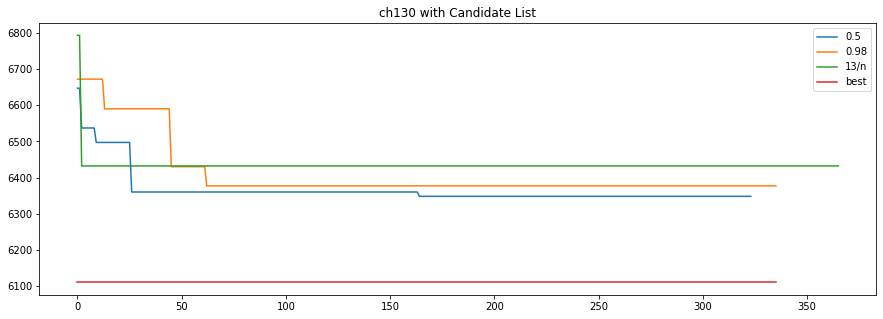

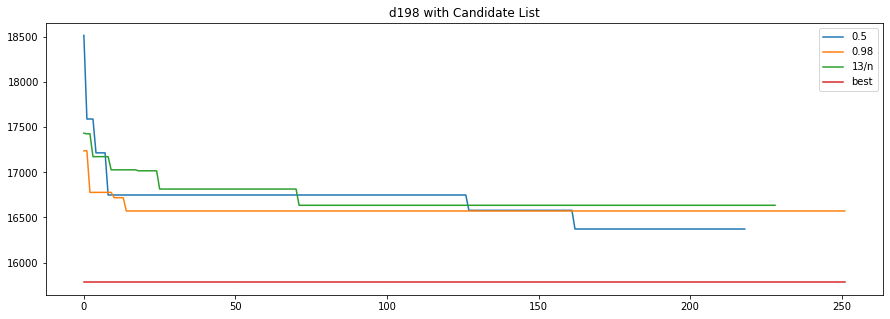

In [9]:
'''
Cumulative best tour WITH CL compared to optimal solution
'''

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(111)
plt.plot(range(len(acs_eil76_05_cl_0.best_distance_list)), acs_eil76_05_cl_0.best_distance_list)
plt.plot(range(len(acs_eil76_098_cl_0.best_distance_list)), acs_eil76_098_cl_0.best_distance_list, label='0.98')
plt.plot(range(len(acs_eil76_13n_cl_0.best_distance_list)), acs_eil76_13n_cl_0.best_distance_list, label='13/n')
plt.plot(range(len(acs_eil76_098_cl_0.best_distance_list)), [ic1.best_sol for i in range(len(acs_eil76_098_cl_0.best_distance_list))], label='best') #best sol
plt.title('eil76 with Candidate List')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(111)
plt.plot(range(len(acs_ch130_05_cl_0.best_distance_list)), acs_ch130_05_cl_0.best_distance_list, label='0.5')
plt.plot(range(len(acs_ch130_098_cl_0.best_distance_list)), acs_ch130_098_cl_0.best_distance_list, label='0.98')
plt.plot(range(len(acs_ch130_13n_cl_0.best_distance_list)), acs_ch130_13n_cl_0.best_distance_list, label='13/n')
plt.plot(range(len(acs_ch130_098_cl_0.best_distance_list)), [ic2.best_sol for i in range(len(acs_ch130_098_cl_0.best_distance_list))], label='best') #best sol
plt.title('ch130 with Candidate List')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(111)
plt.plot(range(len(acs_d198_05_cl_0.best_distance_list)), acs_d198_05_cl_0.best_distance_list, label='0.5')
plt.plot(range(len(acs_d198_098_cl_0.best_distance_list)), acs_d198_098_cl_0.best_distance_list, label='0.98')
plt.plot(range(len(acs_d198_13n_cl_0.best_distance_list)), acs_d198_13n_cl_0.best_distance_list, label='13/n')
plt.plot(range(len(acs_d198_098_cl_0.best_distance_list)), [ic3.best_sol for i in range(len(acs_d198_098_cl_0.best_distance_list))], label='best') #best sol
plt.title('d198 with Candidate List')
plt.legend()
plt.show()

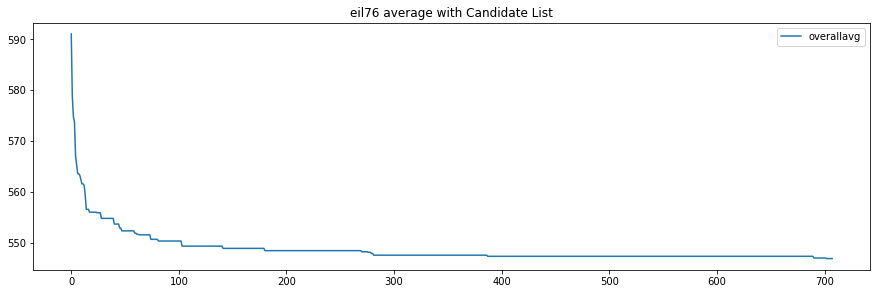

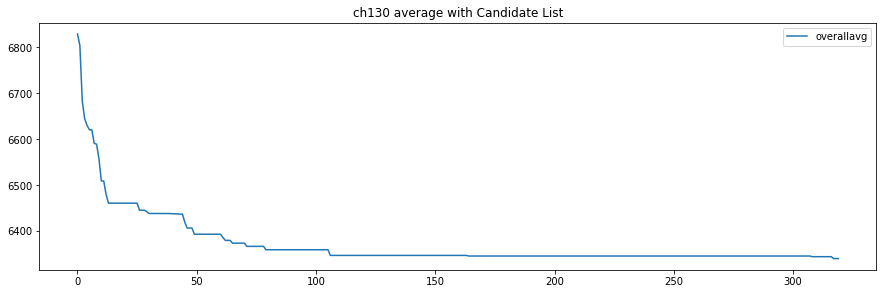

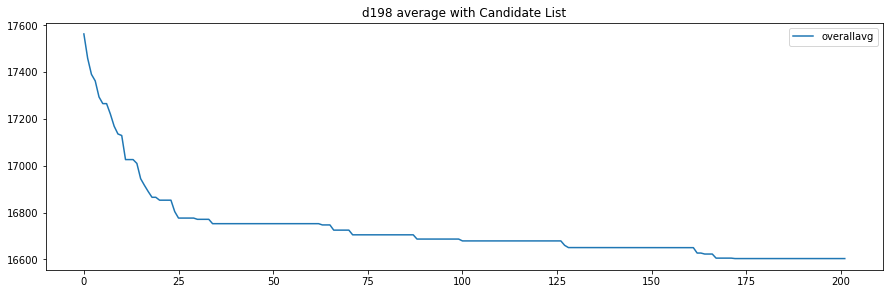

In [21]:
#mean values across iterations WITH CL
 
avg05 = []
avg098 = []
avg13n = []
overall_avg = []
# eil76 stats

for i in range(len(acs_eil76_098_cl_0.best_distance_list)): 
  avg05.append(acs_eil76_05_cl_0.best_distance_list[i]/3 + acs_eil76_05_cl_1.best_distance_list[i]/3 + acs_eil76_05_cl_2.best_distance_list[i]/3) 
  avg098.append(acs_eil76_098_cl_0.best_distance_list[i]/3 + acs_eil76_098_cl_1.best_distance_list[i]/3 + acs_eil76_098_cl_2.best_distance_list[i]/3)
  avg13n.append(acs_eil76_13n_cl_0.best_distance_list[i]/3 + acs_eil76_13n_cl_1.best_distance_list[i]/3 + acs_eil76_13n_cl_2.best_distance_list[i]/3)
for i in range(len(acs_eil76_098_cl_0.best_distance_list)) :
  overall_avg.append(avg05[i]/3 + avg098[i]/3 + avg13n[i]/3)
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('eil76 average with Candidate List')
plt.legend()
plt.show()

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# ch130 stats
for i in range(len(acs_ch130_05_cl_2.best_distance_list)): 
  avg05.append(acs_ch130_05_cl_0.best_distance_list[i]/3 + acs_ch130_05_cl_1.best_distance_list[i]/3 + acs_ch130_05_cl_2.best_distance_list[i]/3) 
  avg098.append(acs_ch130_098_cl_0.best_distance_list[i]/3 + acs_ch130_098_cl_1.best_distance_list[i]/3 + acs_ch130_098_cl_2.best_distance_list[i]/3)
  avg13n.append(acs_ch130_13n_cl_0.best_distance_list[i]/3 + acs_ch130_13n_cl_1.best_distance_list[i]/3 + acs_ch130_13n_cl_2.best_distance_list[i]/3)

for i in range(len(acs_ch130_05_cl_2.best_distance_list)) :
  overall_avg.append(avg05[i]/3 + avg098[i]/3 + avg13n[i]/3)
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('ch130 average with Candidate List')
plt.legend()
plt.show()

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# d198 stats
for i in range(len(acs_d198_098_cl_2.best_distance_list)): 
  avg05.append(acs_d198_05_cl_0.best_distance_list[i]/3 + acs_d198_05_cl_1.best_distance_list[i]/3 + acs_d198_05_cl_2.best_distance_list[i]/3) 
  avg098.append(acs_d198_098_cl_0.best_distance_list[i]/3 + acs_d198_098_cl_1.best_distance_list[i]/3 + acs_d198_098_cl_2.best_distance_list[i]/3)
  avg13n.append(acs_d198_13n_cl_0.best_distance_list[i]/3 + acs_d198_13n_cl_1.best_distance_list[i]/3 + acs_d198_13n_cl_2.best_distance_list[i]/3)

for i in range(len(acs_d198_098_cl_2.best_distance_list)):
  overall_avg.append(avg05[i]/3 + avg098[i]/3 + avg13n[i]/3)
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('d198 average with Candidate List')
plt.legend()
plt.show()